In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import os

#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage import color, util, exposure
from skimage.morphology import disk
from skimage.filters import rank

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.6.0


In [2]:
import wandb
from wandb.keras import WandbCallback

WANDB_NOTEBOOK_NAME='SandNetModel-Functional_Multiout'
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chk_null (use `wandb login --relogin` to force relogin)


True

In [3]:
#code for GPU mem growth

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
#Check for GPU utilization
for gpu in tf.config.list_physical_devices('GPU'):
    print(gpu)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Read data and Preprocess

#### Adaptive EQ Processing

In [5]:
# from os import walk
# from skimage import io

# f = []
# for (dirpath, dirnames, filenames) in walk(train_data_dir):
#     f.extend(filenames)
# f

# for each in f:
# #     print(train_data_direach)
#     img = io.imread(train_data_dir+'/'+each)
#     img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
#     io.imsave('../data/Processed/'+each, img_adapteq)

#### Read Image Attributes

In [6]:
#data
df = pd.read_csv('../data/SedMLdata.csv')
df.head()

,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm,skew,kurtosis
0,F1crop1.jpg,0.202,0.255,0.328,0.417,0.600,1.049,1.475,1.690,1.941,2.243,2.621,-0.310,0.992
1,F1crop2.jpg,0.168,0.194,0.224,0.256,0.305,0.481,0.974,1.420,2.143,2.982,3.980,0.298,0.965
2,F1crop3.jpg,0.128,0.144,0.160,0.176,0.198,0.304,0.540,0.700,0.897,1.172,1.598,0.247,0.857
3,F1crop4.jpg,0.218,0.273,0.346,0.429,0.621,1.283,1.821,2.040,2.241,2.532,2.873,-0.398,0.850
4,F1crop5.jpg,0.134,0.153,0.174,0.194,0.221,0.332,0.780,1.139,1.532,1.851,2.376,0.384,0.810


#### For functional api Multi-Output

In [7]:
# Define dirs and files
train_data_dir = '../data/Processed/'
# train_data_dir = '../data/CropPics/Pics/' #unprocessed original pictures

In [8]:
split = 0.2

#set batch Size
batch_size = 4

# c_ch = 1
# c_mode = 'grayscale'
c_ch = 3
c_mode = 'rgb'

#set Image size (RGB so imshape is 3)
pix_dim = 1024
imsize = (pix_dim, pix_dim) 
imshape = (pix_dim, pix_dim, c_ch)


df = pd.read_csv('../data/SedMLdata.csv')
columns=["D2mm", "D5mm", "D10mm", "D16mm",
"D25mm","D50mm", "D75mm", "D84mm", "D90mm",
"D95mm", "D98mm", "skew", "kurtosis"]



train_datagen = ImageDataGenerator(
                                   rescale = 1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode='nearest',
                                   validation_split = split,
                                  )

def multiple_outputs(generator, dataframe, image_dir, columns,class_mode, batch_size, color_mode, imsize, subset):
    gen = train_datagen.flow_from_dataframe(
        dataframe = dataframe,
        directory = image_dir,
        class_mode = 'raw',
        fill_mode='nearest',
        target_size=imsize,
        batch_size=batch_size,
        x_col = 'CropName',
        y_col = columns,
        color_mode = color_mode,
        use_multiprocessing=True,
        subset=subset)
    
    while True:
        gnext = gen.next()
        # return image batch and 3 sets of lables (Distribution, [Skew,Kurt])
        yield gnext[0], [gnext[1][:,:11], gnext[1][:,11].reshape(-1,1), gnext[1][:,12].reshape(-1,1)]

train_generator = multiple_outputs(generator=train_datagen,
                                   dataframe = df,
                                   image_dir = train_data_dir,
                                   batch_size = batch_size,
                                   class_mode = 'raw',
                                   imsize = imsize,
                                   columns=columns,
                                   color_mode = c_mode,
                                   subset = 'training')
validation_generator =  multiple_outputs(
                                   generator=train_datagen,
                                   dataframe=df,
                                   image_dir = train_data_dir,
                                   batch_size = batch_size,
                                   class_mode = 'raw',
                                   imsize = imsize,
                                   columns=columns,
                                   color_mode = c_mode,
                                   subset = 'validation')

##### Check Shape

In [9]:
for each in train_generator:
    print(each[1][0].shape)
    break

Found 240 validated image filenames.
(4, 11)


In [10]:
for each in validation_generator:
    print(each[1][0].shape)
    break

Found 60 validated image filenames.
(4, 11)


In [11]:
total_train = 240
total_val = 60

### Model Development

#### Set Weights and Biases Tracking

In [12]:
# define other metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError(name='mae')
mape_metric = tf.keras.metrics.MeanAbsolutePercentageError(name='mape')

wandb.init(
  project="sandcam_2",
  # Set entity to specify your username or team name
  # ex: entity="wandb",
  config={
      "activation": "gelu",
      "dlayer_0": 512,
      "activation_0": "relu",
      "dlayer_1": 128,
      "activation_1": "relu",
      "dropout": 0.5,
      "dlayer_2": 64,
      "activation_2": "relu",
      "dlayer_dist": 11,
      "activation_dist": "relu",
      "dlayer_skew": 1,
      "activation_skew": "relu",
      "dlayer_kurt": 1,
      "activation_kurt": "relu",
      "optimizer": "Adam",
      "loss": 'mean_squared_error',
      "metric": "accuracy",
      "epoch": 50,
      "batch_size": 4,
      "loss_weights": [0.1, 0.1, 0.1, 0.2, 0.5, 1, 0.5, 0.2, 0.1, 0.1, 0.1 ]
      
  })
config = wandb.config

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


##### Base Model

Fixed kernel size

In [13]:
# inp = layers.Input(shape=imshape)

# cnn1 = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(inp)
# # bn1 = layers.BatchNormalization()(cnn1)
# mp1 = layers.MaxPool2D()(cnn1)
# dr1 = layers.Dropout(config.dropout)(mp1)

# cnn2 = layers.Conv2D(64, 3, padding='same', activation='relu')(dr1)
# cnn3 = layers.Conv2D(64, 3, padding='same', activation='relu')(cnn2)
# # bn2 = layers.BatchNormalization()(cnn3)
# mp2 = layers.MaxPool2D()(cnn3)
# dr2 = layers.Dropout(config.dropout)(mp2)

# cnn4 = layers.Conv2D(128, 3, padding='same', activation='relu')(dr2)
# cnn5 = layers.Conv2D(128, 3, padding='same', activation='relu')(cnn4)
# # bn3 = layers.BatchNormalization()(cnn5)
# mp3 = layers.MaxPool2D()(cnn5)
# dr3 = layers.Dropout(config.dropout)(mp3)

# cnn6 = layers.Conv2D(128, 3, padding='same', activation='relu')(dr3)
# cnn7 = layers.Conv2D(128, 3, padding='same', activation='relu')(cnn6)
# # bn4 = layers.BatchNormalization()(cnn7)
# mp4 = layers.MaxPool2D()(cnn7)
# dr4 = layers.Dropout(config.dropout)(mp4)

# gp1 = layers.GlobalMaxPooling2D()(dr4)
    
# d1 = layers.Dense(config.dlayer_0, activation=config.activation_0)(gp1)
# dr5 = layers.Dropout(config.dropout)(d1)

# d2 = layers.Dense(config.dlayer_1, activation=config.activation_1)(dr5)
# dr6 = layers.Dropout(config.dropout)(d2)

# d3 = layers.Dense(config.dlayer_2, activation=config.activation_2)(dr6)
# dr7 = layers.Dropout(config.dropout)(d3)
    
# dr_skew = layers.Dense(config.dlayer_skew, activation=config.activation_skew, name='Skew')(dr7)

# dr_kurt = layers.Dense(config.dlayer_kurt, activation=config.activation_kurt, name='Kurt')(dr7)

# combo = layers.concatenate([dr7, dr_skew, dr_kurt])

# dr_dist = layers.Dense(11, activation=config.activation_dist, name='Dist')(combo)

# # dr_dist = layers.Dense(11, activation=config.activation_dist, name='Dist')(dr7)



# model = Model(inp, [dr_dist, dr_skew, dr_kurt])

# # model = Model(inp, [dr_dist])

# model._name = "SandCam_CNN"

# initial_learning_rate = 0.0001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96,
#     staircase=True)

# # opt = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, decay=1e-2/200)
# opt = tf.keras.optimizers.Adam()

# model.compile(loss={
#                 'Dist':'mean_squared_error',
#                 'Skew':'mean_squared_error',
#                 'Kurt':'mean_squared_error',
#                 }, 
#                   optimizer=opt,
#                   metrics = mape_metric
#          )


##### Larger Model

Larger number of filters

In [14]:
# baseFilter= 32

# inp = layers.Input(shape=imshape)

# cnn0 = layers.SeparableConv2D(filters = baseFilter, kernel_size=3, padding='same', activation='relu')(inp)
# cnn1 = layers.SeparableConv2D(baseFilter*2, 3, padding='same', activation='relu')(cnn0)
# mp1 = layers.MaxPool2D()(cnn1)
# dr1 = layers.Dropout(config.dropout)(mp1)

# cnn2 = layers.SeparableConv2D(baseFilter*3, 3, padding='same', activation='relu')(dr1)
# mp2 = layers.MaxPool2D()(cnn2)
# dr2 = layers.Dropout(config.dropout)(mp2)

# cnn3 = layers.SeparableConv2D(baseFilter*3, 3, padding='same', activation='relu')(dr2)
# mp3 = layers.MaxPool2D()(cnn3)
# dr3 = layers.Dropout(config.dropout)(mp3)

# cnn4 = layers.SeparableConv2D(baseFilter*4, 3, padding='same', activation='relu')(dr3)
# mp4 = layers.MaxPool2D()(cnn4)
# dr4 = layers.Dropout(config.dropout)(mp4)

# cnn5 = layers.SeparableConv2D(baseFilter*5, 3, padding='same', activation='relu')(dr4)
# mp5 = layers.MaxPool2D()(cnn5)
# dr5 = layers.Dropout(config.dropout)(mp5)

# cnn6 = layers.SeparableConv2D(baseFilter*6, 3, padding='same', activation='relu')(dr5)
# mp6 = layers.MaxPool2D()(cnn6)
# dr6 = layers.Dropout(config.dropout)(mp6)

# cnn7 = layers.SeparableConv2D(baseFilter*7, 3, padding='same', activation='relu')(dr6)
# mp7 = layers.MaxPool2D()(cnn7)
# dr7 = layers.Dropout(config.dropout)(mp7)

# gp1 = layers.GlobalMaxPooling2D()(dr7)
    
# d1 = layers.Dense(config.dlayer_0, activation=config.activation_0)(gp1)
# dr8 = layers.Dropout(config.dropout)(d1)

# d2 = layers.Dense(config.dlayer_1, activation=config.activation_1)(dr8)
# dr9 = layers.Dropout(config.dropout)(d2)

# d3 = layers.Dense(config.dlayer_2, activation=config.activation_2)(dr9)
# dr10 = layers.Dropout(config.dropout)(d3)
    
# dr_skew = layers.Dense(config.dlayer_skew, activation=config.activation_skew, name='Skew')(dr10)

# dr_kurt = layers.Dense(config.dlayer_kurt, activation=config.activation_kurt, name='Kurt')(dr10)

# combo = layers.concatenate([dr10, dr_skew, dr_kurt])

# dr_dist = layers.Dense(11, activation=config.activation_dist, name='Dist')(combo)

# # dr_dist = layers.Dense(11, activation=config.activation_dist, name='Dist')(dr7)



# model = Model(inp, [dr_dist, dr_skew, dr_kurt])

# # model = Model(inp, [dr_dist])

# model._name = "SandCam_CNN"

# initial_learning_rate = 0.0001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96,
#     staircase=True)

# # opt = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, decay=1e-2/200)
# opt = tf.keras.optimizers.Adam()

# model.compile(loss={
#                 'Dist':'mean_squared_error',
#                 'Skew':'mean_squared_error',
#                 'Kurt':'mean_squared_error',
#                 }, 
#                   optimizer=opt,
#                   metrics = mape_metric
#          )


##### Residual Model 1

Skip connections with Relu and BatchNorm

In [15]:
# baseFilter= 32

# inp = layers.Input(shape=imshape)

# cnn0 = layers.SeparableConv2D(filters = baseFilter, kernel_size=3, padding='same', activation='relu')(inp)
# cnn1 = layers.SeparableConv2D(baseFilter*2, 3, padding='same', activation='relu')(cnn0)
# mp1 = layers.MaxPool2D()(cnn1)
# dr1 = layers.Dropout(config.dropout)(mp1)

# cnn2 = layers.SeparableConv2D(baseFilter*3, 3, padding='same', activation='relu')(dr1)
# mp2 = layers.MaxPool2D()(cnn2)
# dr2 = layers.Dropout(config.dropout)(mp2)

# ## residual

# res1 = layers.Add([dr1, dr2])
# act1 = layers.ReLU()(res1)
# out1 = layers.BatchNormalization()(act1)

# cnn3 = layers.SeparableConv2D(baseFilter*3, 3, padding='same', activation='relu')(act1)
# mp3 = layers.MaxPool2D()(cnn3)
# dr3 = layers.Dropout(config.dropout)(mp3)


# ## residual

# res2 = layers.Add([out1, dr3])
# act2 = layers.ReLU()(res2)
# out2 = layers.BatchNormalization()(act2)

# cnn4 = layers.SeparableConv2D(baseFilter*4, 3, padding='same', activation='relu')(out2)
# mp4 = layers.MaxPool2D()(cnn4)
# dr4 = layers.Dropout(config.dropout)(mp4)

# ## residual

# res3 = layers.Add([out2, dr4])
# act3 = layers.ReLU()(res3)
# out3 = layers.BatchNormalization()(act3)


# cnn5 = layers.SeparableConv2D(baseFilter*5, 3, padding='same', activation='relu')(out3)
# mp5 = layers.MaxPool2D()(cnn5)
# dr5 = layers.Dropout(config.dropout)(mp5)

# ## residual

# res4 = layers.Add([out3, dr5])
# act4 = layers.ReLU()(res4)
# out4 = layers.BatchNormalization()(act4)


# cnn6 = layers.SeparableConv2D(baseFilter*6, 3, padding='same', activation='relu')(act4)
# mp6 = layers.MaxPool2D()(cnn6)
# dr6 = layers.Dropout(config.dropout)(mp6)

# ## residual

# res5 = layers.Add([out4, dr6])
# act5 = layers.ReLU()(res5)
# out5 = layers.BatchNormalization()(act5)


# cnn7 = layers.SeparableConv2D(baseFilter*7, 3, padding='same', activation='relu')(out5)
# mp7 = layers.MaxPool2D()(cnn7)
# dr7 = layers.Dropout(config.dropout)(mp7)

# ## residual

# res6 = layers.Add([out5, dr7])
# act6 = layers.ReLU()(res6)
# out6 = layers.BatchNormalization()(act6)


# gp1 = layers.GlobalMaxPooling2D()(out6)
    
# d1 = layers.Dense(config.dlayer_0, activation=config.activation_0)(gp1)
# dr5 = layers.Dropout(config.dropout)(d1)

# d2 = layers.Dense(config.dlayer_1, activation=config.activation_1)(dr5)
# dr6 = layers.Dropout(config.dropout)(d2)

# d3 = layers.Dense(config.dlayer_2, activation=config.activation_2)(dr6)
# dr7 = layers.Dropout(config.dropout)(d3)
    
# dr_skew = layers.Dense(config.dlayer_skew, activation=config.activation_skew, name='Skew')(dr7)

# dr_kurt = layers.Dense(config.dlayer_kurt, activation=config.activation_kurt, name='Kurt')(dr7)

# combo = layers.concatenate([dr7, dr_skew, dr_kurt])

# dr_dist = layers.Dense(11, activation=config.activation_dist, name='Dist')(combo)

# # dr_dist = layers.Dense(11, activation=config.activation_dist, name='Dist')(dr7)



# model = Model(inp, [dr_dist, dr_skew, dr_kurt])

# # model = Model(inp, [dr_dist])

# model._name = "SandCam_CNN"

# initial_learning_rate = 0.0001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96,
#     staircase=True)

# # opt = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, decay=1e-2/200)
# opt = tf.keras.optimizers.Adam()

# model.compile(loss={
#                 'Dist':'mean_squared_error',
#                 'Skew':'mean_squared_error',
#                 'Kurt':'mean_squared_error',
#                 }, 
#                   optimizer=opt,
#                   metrics = mape_metric
#          )


##### Residual Model 2

Skip connections with Gelu and BatchNorm

In [16]:
# def relu_bn(inputs: tf.Tensor) -> tf.Tensor:
#     relu = layers.ReLU()(inputs)
#     bn = layers.BatchNormalization()(relu)
#     return bn

# def residual_block(x: tf.Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> tf.Tensor:
#     y = layers.Conv2D(kernel_size=kernel_size,
#                strides= (1 if not downsample else 2),
#                filters=filters,
#                padding="same")(x)
#     y = relu_bn(y)
#     y = layers.Conv2D(kernel_size=kernel_size,
#                strides=1,
#                filters=filters,
#                padding="same")(y)

#     if downsample:
#         x = layers.Conv2D(kernel_size=1,
#                    strides=2,
#                    filters=filters,
#                    padding="same")(x)
#     out = layers.Add()([x, y])
#     out = relu_bn(out)
#     return out

# num_filters = 32
# inp = layers.Input(shape=imshape)

# t = layers.BatchNormalization()(inp)
# t = layers.Conv2D(kernel_size=3,
#            strides=1,
#            filters=num_filters,
#            padding="same")(t)
# t = relu_bn(t)

# num_blocks_list = [2]
# for i in range(len(num_blocks_list)):
#     num_blocks = num_blocks_list[i]
#     for j in range(num_blocks):
#         t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
#     num_filters *= 2
    
# gp1 = layers.GlobalMaxPooling2D()(t)

# d1 = layers.Dense(config.dlayer_0, activation=config.activation)(gp1)
# dr8 = layers.Dropout(config.dropout)(d1)

# d2 = layers.Dense(config.dlayer_1, activation=config.activation)(dr8)
# dr9 = layers.Dropout(config.dropout)(d2)

# d3 = layers.Dense(config.dlayer_2, activation=config.activation)(dr9)
# dr10 = layers.Dropout(config.dropout)(d3)
    
# dr_skew = layers.Dense(config.dlayer_skew, activation="gelu", name='Skew')(dr10)

# dr_kurt = layers.Dense(config.dlayer_kurt, activation="gelu", name='Kurt')(dr10)

# combo = layers.concatenate([dr10, dr_skew, dr_kurt])

# dr_dist = layers.Dense(11, activation=config.activation, name='Dist')(combo)

# model = Model(inp, [dr_dist, dr_skew, dr_kurt])

# # model = Model(inp, [dr_dist])

# model._name = "SandCam_CNN"

# initial_learning_rate = 0.0001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96,
#     staircase=True)

# # opt = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, decay=1e-2/200)
# opt = tf.keras.optimizers.Adam()

# model.compile(loss={
#                 'Dist':'mean_squared_error',
#                 'Skew':'mean_squared_error',
#                 'Kurt':'mean_squared_error',
#                 }, 
#                   optimizer=opt,
#                   metrics = mape_metric
#          )

##### Large Model

Larger kernel size with Gelu activations (Currently the best model)

In [17]:
baseFilter= 32
kernelSize = 6

inp = layers.Input(shape=imshape)

cnn0 = layers.SeparableConv2D(filters = baseFilter, kernel_size=kernelSize, padding='same', activation='gelu')(inp)
mp1 = layers.MaxPool2D()(cnn0)
dr1 = layers.Dropout(config.dropout)(mp1)

cnn1 = layers.SeparableConv2D(baseFilter*2, kernel_size=kernelSize, padding='same', activation='gelu')(dr1)
cnn2 = layers.SeparableConv2D(baseFilter*2, kernel_size=kernelSize, padding='same', activation='gelu')(cnn1)
mp2 = layers.MaxPool2D()(cnn2)
dr2 = layers.Dropout(config.dropout)(mp2)

cnn3 = layers.SeparableConv2D(baseFilter*4, kernel_size=kernelSize, padding='same', activation='gelu')(dr2)
cnn4 = layers.SeparableConv2D(baseFilter*4, kernel_size=kernelSize, padding='same', activation='gelu')(cnn1)
mp3 = layers.MaxPool2D()(cnn4)
dr3 = layers.Dropout(config.dropout)(mp3)

cnn4 = layers.SeparableConv2D(baseFilter*4, kernel_size=kernelSize, padding='same', activation='gelu')(dr3)
cnn5 = layers.SeparableConv2D(baseFilter*4, kernel_size=kernelSize, padding='same', activation='gelu')(cnn4)
mp4 = layers.MaxPool2D()(cnn5)
dr4 = layers.Dropout(config.dropout)(mp4)

gp1 = layers.GlobalMaxPooling2D()(dr4)
    
d1 = layers.Dense(config.dlayer_0, activation=config.activation)(gp1)
dr8 = layers.Dropout(config.dropout)(d1)

d2 = layers.Dense(config.dlayer_1, activation=config.activation)(dr8)
dr9 = layers.Dropout(config.dropout)(d2)

d3 = layers.Dense(config.dlayer_2, activation=config.activation)(dr9)
dr10 = layers.Dropout(config.dropout)(d3)
    
dr_skew = layers.Dense(config.dlayer_skew, activation="gelu", name='Skew')(dr10)

dr_kurt = layers.Dense(config.dlayer_kurt, activation="gelu", name='Kurt')(dr10)

combo = layers.concatenate([dr10, dr_skew, dr_kurt])

dr_dist = layers.Dense(11, activation=config.activation, name='Dist')(combo)

model = Model(inp, [dr_dist, dr_skew, dr_kurt])

# model = Model(inp, [dr_dist])

model._name = "SandCam_CNN"

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

# opt = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, decay=1e-2/200)
opt = tf.keras.optimizers.Adam()

model.compile(loss={
                'Dist':'mean_squared_error',
                'Skew':'mean_squared_error',
                'Kurt':'mean_squared_error',
                }, 
                  optimizer=opt,
                  metrics = mape_metric
         )

##### Very Large Model

Larger kernel size with Gelu activations (Was not able to run)

In [18]:
# baseFilter= 32
# kernelSize = 6

# inp = layers.Input(shape=imshape)

# cnn0 = layers.SeparableConv2D(filters = baseFilter, kernel_size=kernelSize, padding='same', activation='relu')(inp)
# cnn1 = layers.SeparableConv2D(baseFilter*2, kernel_size=kernelSize, padding='same', activation='gelu')(cnn0)
# mp1 = layers.MaxPool2D()(cnn1)
# dr1 = layers.Dropout(config.dropout)(mp1)

# cnn2 = layers.SeparableConv2D(baseFilter*3, kernel_size=kernelSize, padding='same', activation='gelu')(dr1)
# mp2 = layers.MaxPool2D()(cnn2)
# dr2 = layers.Dropout(config.dropout)(mp2)

# # cnn3 = layers.SeparableConv2D(baseFilter*3, kernel_size=kernelSize, padding='same', activation='gelu')(dr2)
# # mp3 = layers.MaxPool2D()(cnn3)
# # dr3 = layers.Dropout(config.dropout)(mp3)

# cnn4 = layers.SeparableConv2D(baseFilter*4, kernel_size=kernelSize, padding='same', activation='gelu')(dr2)
# mp4 = layers.MaxPool2D()(cnn4)
# dr4 = layers.Dropout(config.dropout)(mp4)

# # cnn5 = layers.SeparableConv2D(baseFilter*5, kernel_size=kernelSize, padding='same', activation='gelu')(dr4)
# # mp5 = layers.MaxPool2D()(cnn5)
# # dr5 = layers.Dropout(config.dropout)(mp5)

# # cnn6 = layers.SeparableConv2D(baseFilter*6, kernel_size=kernelSize, padding='same', activation='gelu')(dr5)
# # mp6 = layers.MaxPool2D()(cnn6)
# # dr6 = layers.Dropout(config.dropout)(mp6)

# # cnn7 = layers.SeparableConv2D(baseFilter*7, kernel_size=kernelSize, padding='same', activation='gelu')(dr6)
# # mp7 = layers.MaxPool2D()(cnn7)
# # dr7 = layers.Dropout(config.dropout)(mp7)

# gp1 = layers.GlobalMaxPooling2D()(dr4)
    
# d1 = layers.Dense(config.dlayer_0, activation=config.activation)(gp1)
# dr8 = layers.Dropout(config.dropout)(d1)

# d2 = layers.Dense(config.dlayer_1, activation=config.activation)(dr8)
# dr9 = layers.Dropout(config.dropout)(d2)

# d3 = layers.Dense(config.dlayer_2, activation=config.activation)(dr9)
# dr10 = layers.Dropout(config.dropout)(d3)
    
# dr_skew = layers.Dense(config.dlayer_skew, activation="gelu", name='Skew')(dr10)

# dr_kurt = layers.Dense(config.dlayer_kurt, activation="gelu", name='Kurt')(dr10)

# combo = layers.concatenate([dr10, dr_skew, dr_kurt])

# dr_dist = layers.Dense(11, activation=config.activation, name='Dist')(combo)

# # dr_dist = layers.Dense(11, activation=config.activation_dist, name='Dist')(dr7)



# model = Model(inp, [dr_dist, dr_skew, dr_kurt])

# # model = Model(inp, [dr_dist])

# model._name = "SandCam_CNN"

# initial_learning_rate = 0.0001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96,
#     staircase=True)

# # opt = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9, decay=1e-2/200)
# opt = tf.keras.optimizers.Adam()

# model.compile(loss={
#                 'Dist':'mean_squared_error',
#                 'Skew':'mean_squared_error',
#                 'Kurt':'mean_squared_error',
#                 }, 
#                   optimizer=opt,
#                   metrics = mape_metric
#          )


#### Model Architecture

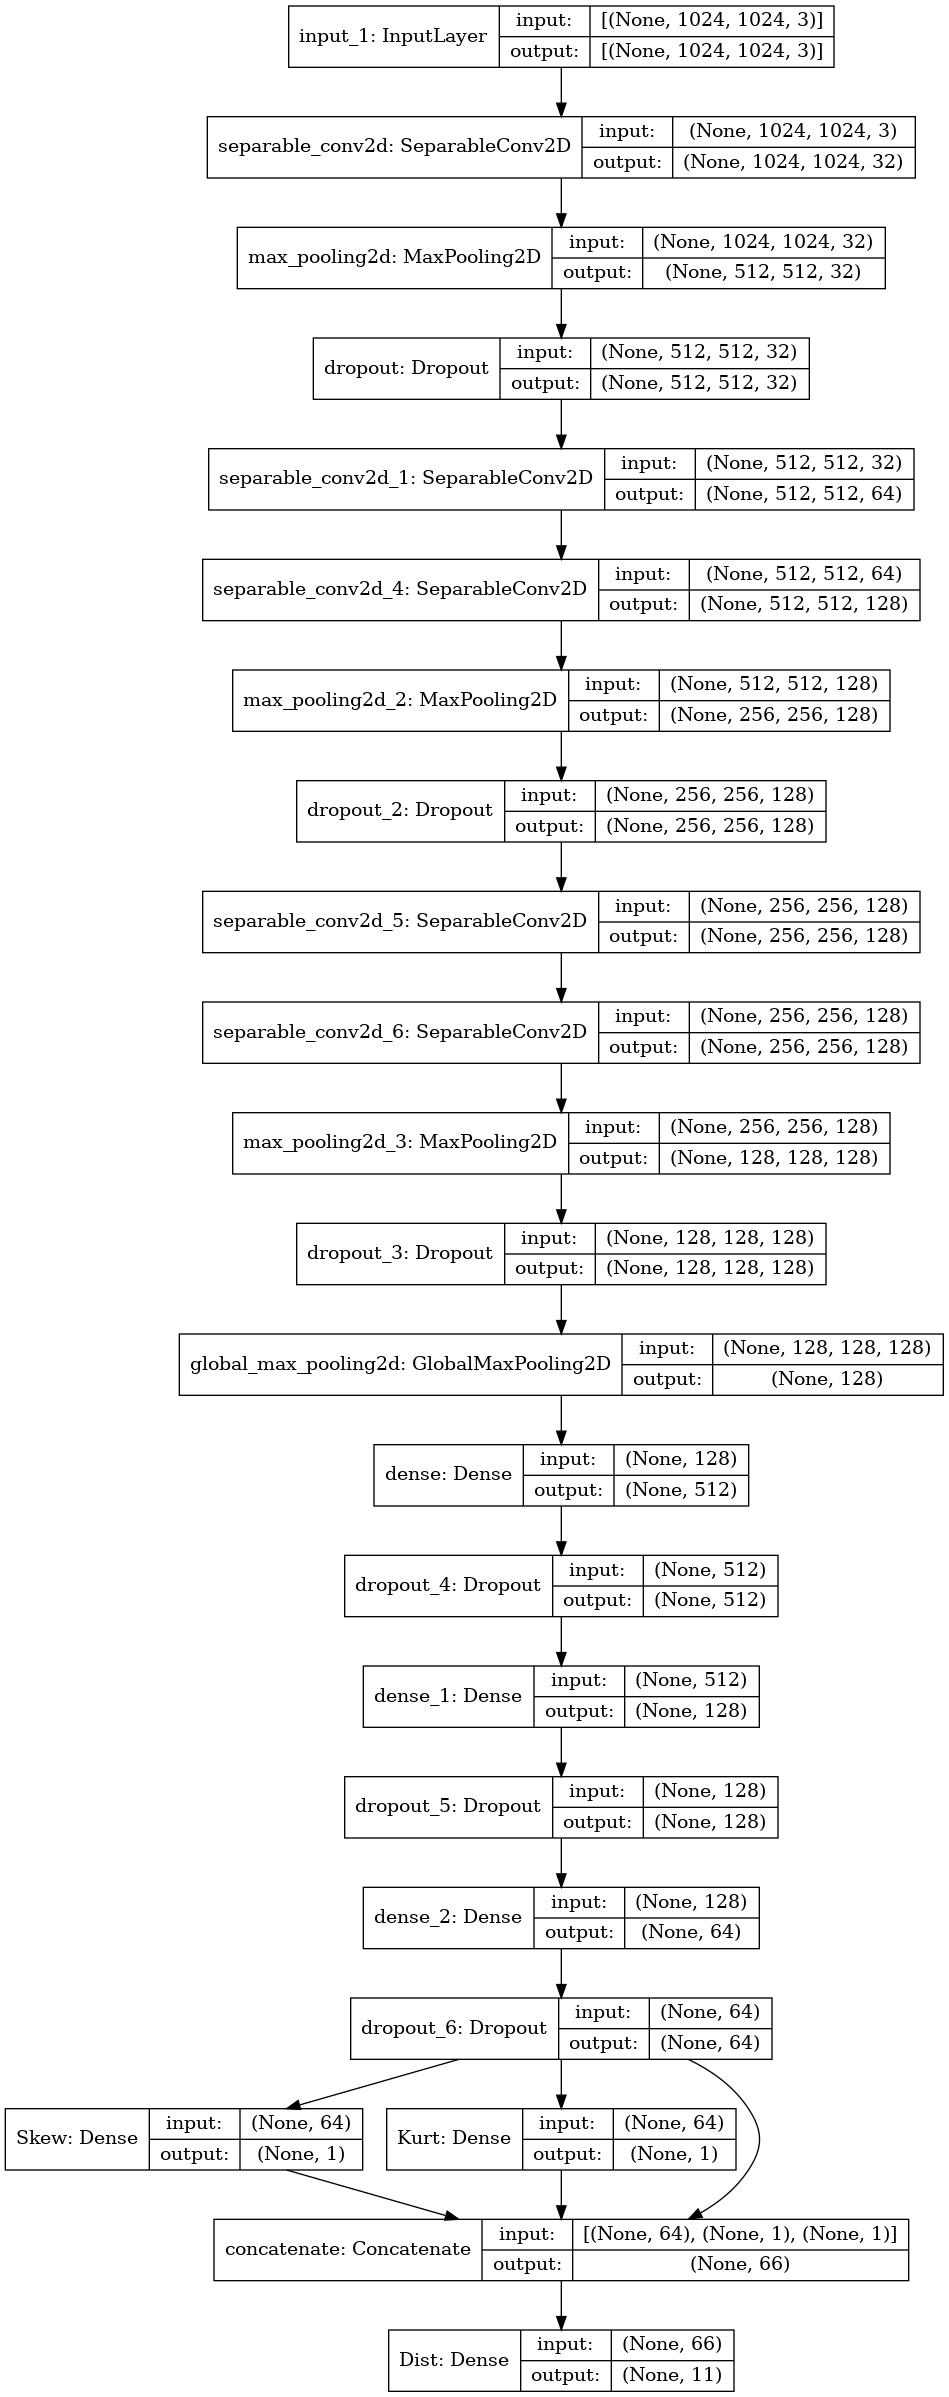

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

##### Callbacks

In [20]:
# define a callback

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 20, 
                                             restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor = 0.02,
                                                 verbose = 1,
                                                 patience=10)


logging_callback = WandbCallback(log_evaluation=True)

##### Train and Validate the model

In [21]:
#train the model
history = model.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    validation_steps =  total_val // batch_size,
                    epochs= 200,
                    
#                     workers = 8,
                    callbacks =[early_stop, reduce_lr, logging_callback])
wandb.finish()

wandb: WARNING WandbCallback is unable to log validation data. When using a generator for validation_data, you must pass validation_steps


Epoch 1/200
60/60 [==============================] - 70s 1s/step - loss: 1.1065 - Dist_loss: 0.6979 - Skew_loss: 0.0486 - Kurt_loss: 0.3600 - Dist_mape: 76.7120 - Skew_mape: 411040.2188 - Kurt_mape: 46.0972 - val_loss: 1.6165 - val_Dist_loss: 1.3183 - val_Skew_loss: 0.0590 - val_Kurt_loss: 0.2391 - val_Dist_mape: 52.3475 - val_Skew_mape: 140.2331 - val_Kurt_mape: 33.5111
Epoch 2/200
60/60 [==============================] - 61s 1s/step - loss: 0.5720 - Dist_loss: 0.4020 - Skew_loss: 0.0493 - Kurt_loss: 0.1207 - Dist_mape: 62.1251 - Skew_mape: 265013.3438 - Kurt_mape: 25.8986 - val_loss: 1.3916 - val_Dist_loss: 1.2024 - val_Skew_loss: 0.0558 - val_Kurt_loss: 0.1334 - val_Dist_mape: 42.6436 - val_Skew_mape: 112.1956 - val_Kurt_mape: 21.9213
Epoch 3/200
60/60 [==============================] - 63s 1s/step - loss: 0.5137 - Dist_loss: 0.3789 - Skew_loss: 0.0467 - Kurt_loss: 0.0880 - Dist_mape: 62.0241 - Skew_mape: 114587.3906 - Kurt_mape: 22.5332 - val_loss: 1.4159 - val_Dist_loss: 1.1689 - 

Epoch 22/200
60/60 [==============================] - 64s 1s/step - loss: 0.4291 - Dist_loss: 0.3386 - Skew_loss: 0.0365 - Kurt_loss: 0.0540 - Dist_mape: 50.7695 - Skew_mape: 604111.3750 - Kurt_mape: 16.8547 - val_loss: 0.7727 - val_Dist_loss: 0.6179 - val_Skew_loss: 0.0505 - val_Kurt_loss: 0.1044 - val_Dist_mape: 39.2629 - val_Skew_mape: 127.1373 - val_Kurt_mape: 19.2770
Epoch 23/200
60/60 [==============================] - 63s 1s/step - loss: 0.4068 - Dist_loss: 0.3111 - Skew_loss: 0.0379 - Kurt_loss: 0.0577 - Dist_mape: 48.5762 - Skew_mape: 298649.5312 - Kurt_mape: 17.3347 - val_loss: 1.0051 - val_Dist_loss: 0.8571 - val_Skew_loss: 0.0577 - val_Kurt_loss: 0.0903 - val_Dist_mape: 37.0509 - val_Skew_mape: 178.2377 - val_Kurt_mape: 21.4083
Epoch 24/200
60/60 [==============================] - 63s 1s/step - loss: 0.4059 - Dist_loss: 0.3196 - Skew_loss: 0.0348 - Kurt_loss: 0.0516 - Dist_mape: 49.8382 - Skew_mape: 402358.1875 - Kurt_mape: 15.7914 - val_loss: 1.0226 - val_Dist_loss: 0.8014

Epoch 44/200
60/60 [==============================] - 63s 1s/step - loss: 0.3547 - Dist_loss: 0.2595 - Skew_loss: 0.0374 - Kurt_loss: 0.0578 - Dist_mape: 43.4047 - Skew_mape: 109267.3906 - Kurt_mape: 18.7869 - val_loss: 0.9276 - val_Dist_loss: 0.7359 - val_Skew_loss: 0.0743 - val_Kurt_loss: 0.1174 - val_Dist_mape: 34.8650 - val_Skew_mape: 154.9283 - val_Kurt_mape: 28.6395
Epoch 45/200
60/60 [==============================] - 64s 1s/step - loss: 0.3623 - Dist_loss: 0.2470 - Skew_loss: 0.0399 - Kurt_loss: 0.0754 - Dist_mape: 43.4633 - Skew_mape: 377214.1875 - Kurt_mape: 21.6698 - val_loss: 0.8584 - val_Dist_loss: 0.6590 - val_Skew_loss: 0.0653 - val_Kurt_loss: 0.1341 - val_Dist_mape: 33.2390 - val_Skew_mape: 152.7230 - val_Kurt_mape: 28.2418
Epoch 46/200
60/60 [==============================] - 63s 1s/step - loss: 0.3674 - Dist_loss: 0.2427 - Skew_loss: 0.0368 - Kurt_loss: 0.0880 - Dist_mape: 41.8525 - Skew_mape: 222674.0000 - Kurt_mape: 23.3114 - val_loss: 0.9250 - val_Dist_loss: 0.7145

Widget Javascript not detected.  It may not be installed or enabled properly.


Dist_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁
Dist_mape,█▅▅▄▄▄▄▃▄▃▃▃▃▂▂▃▂▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
Kurt_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▂▁▂▂▁▂▂▂▂▂▂▂▂
Kurt_mape,█▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▂▂▂▃▂▃▂▃▂▂▂▂▃▃▃▃▃▂▂▂
Skew_loss,██▇▅▅▄▄▃▄▃▃▂▃▂▄▃▃▂▃▃▂▂▃▂▃▃▃▁▄▁▄▃▃▄▃▄▃▂▄▃
Skew_mape,▄▃▂▂▂▃▄▃█▄█▆▁▆▅▅▃▄▇▄▃▃▂▄▃▂▁▄▃▄▁▂▂▄▂▄▄▃▃▄
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,█████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_Dist_loss,█▇▇▃▅▃▅▄▃▆▄▄▄▄▅▃▄▄▃▄▃▃▂▃▆▁▄▃▄▄▂▄▃▂▄▅▂▂▅▃
val_Dist_mape,█▅▆▄▄▄▃▃▃▄▄▄▃▄▄▄▃▃▃▂▂▂▂▃▃▂▃▁▂▂▂▃▂▂▂▃▂▁▃▂


#### Model Performance

In [25]:
from IPython.display import IFrame

IFrame("https://wandb.ai/chk_null/sandcam_2/workspace?workspace=user-chk_null", width="100%", height=720)

### Saved Models

#### Original Model

In [23]:
#save the model
filepath = './log/saved_model/sandcam-multiout.h5'
model.save(filepath)


In [24]:
#model size

print(
    "Size of the model: %.2f Mb"
    % (os.path.getsize(filepath) / float(2 ** 20))
)


Size of the model: 2.38 Mb
